In [2]:
pip install graphviz

     |████████████████████████████████| 47 kB 1.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install termcolor2

  Created wheel for termcolor2: filename=termcolor2-0.0.3-py3-none-any.whl size=1834 sha256=da4bde6417f61ffa6b23018cce52fa6c63d60b48165786cc890ef5d5dd1773ae
  Stored in directory: /Users/raj8lm/Library/Caches/pip/wheels/37/93/fa/3ead517c143d4381f9b4096524f21b1d86a5fa60d08210abe8
Successfully built termcolor2
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install typing

     |████████████████████████████████| 78 kB 2.5 MB/s eta 0:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=a76f6ce3d6a294eb996173d79691467d807728f3680113e7f9f316439324e645
  Stored in directory: /Users/raj8lm/Library/Caches/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install yellowbrick

     |████████████████████████████████| 282 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import graphviz
import itertools
import matplotlib.pyplot as plt # graphing with insane defaults
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # graphing with sane defaults
import scipy.stats as stats
from sklearn import linear_model
from sklearn import preprocessing # Preprocess data (e.g. scale numerical data to 0-1
from sklearn import tree
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, IsolationForest
from sklearn.feature_selection import SelectFromModel
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.utils._testing import ignore_warnings
from termcolor import colored, cprint
import typing # Apply common types to objects)
import warnings
from yellowbrick.features import PCA as yellowPCA, Manifold
from yellowbrick.regressor import ResidualsPlot, PredictionError
import plotly.express as px

warnings.simplefilter(action='ignore', category=FutureWarning)

feature_engineering = typing.TypeVar('rabbitml.feature_engineering')

class rabbitml:
    """
    An automl library designed for tabular data

    @Taran Sean Marley 
    https://www.kaggle.com/taranmarley
    """
    class feature_engineering:
        """
        A class intended to move through and improve the features of a dataset.
        """
        
        def auto_casefold(self, df : pd.DataFrame) -> pd.DataFrame:
            """
            Take a dataframe, find the string columns and convert them all to lower case through casefold

            Parameters
            ----------
            dataframe : pd.DataFrame
                The dataframe to casefold over to convert to lower case

            Returns
            -------
            pd.DataFrame
                The same dataframe given with the new lorrrwer case values if applied

            """
            for col in df.columns:
                if self.is_string_type(df[col]):
                    df[col] = df[col].astype(str).str.casefold()
            return df

        def break_up_by_string(self, df_temp : pd.DataFrame, splitting_string : str) -> pd.DataFrame:
            """
            Break up columns by string to create new columns from each split.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to start splitting up object columns
            splitting_string : str
                String to split up columns by


            Returns
            -------
            pd.DataFrame
                modified dataframe with extra columns containing split up values
            """
            obj_cols = df_temp.select_dtypes(include=[object])
            # count spaces
            for col in obj_cols:
                if df_temp[col].str.contains(splitting_string).sum() > 0:
                    df2 = df_temp[col].str.split(splitting_string, expand=True)
                    # Rename columns
                    rename_dict = {}
                    for rename_col in df2.columns:
                        if (splitting_string != " "):
                            rename_dict[rename_col] = col + splitting_string + str(rename_col)
                        else:
                            rename_dict[rename_col] = col + str(rename_col)
                    df2 = df2.rename(columns=rename_dict)
                    df2 = df2.fillna(0)
                    df_temp = pd.concat([df_temp,df2], axis=1) 
            return df_temp
        
        def compare_object_columns(self, df_temp : pd.DataFrame, df_temp_2 : pd.DataFrame, silent = False, replace = False) -> None:
            """
            Compare object columns and print out the if there is a difference between them. This helps determining the differences between a test dataframe and a training dataframe
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                First dataframe to compare columns with
            df_temp_2 : pd.DataFrame
                Second dataframe to compare columns with
            silent : bool
                Print the results or not
            replace : bool
                Replace bad values in df_temp with NaN values
            """
            for col in df_temp.select_dtypes(include="object").columns:
                if col in df_temp_2.columns:
                    unique_df_list = df_temp[col].unique().tolist()
                    test_df_list = df_temp_2[col].unique().tolist()
                    if set(unique_df_list) != set(test_df_list):
                        unique_df_list = ["nan" if x is np.nan else x for x in unique_df_list]
                        test_df_list = ["nan" if x is np.nan else x for x in test_df_list] 
                        unique_df_list.sort()
                        test_df_list.sort()
                        # Print lists if requested
                        if not silent:
                            print("***",col)
                            print(unique_df_list)
                            print(test_df_list)
                        # Replace with NaN if requested by parameter 
                        for x in unique_df_list:
                            if x not in test_df_list:
                                df_temp[col].replace({x:np.nan})
                                
        def create_anomaly_scores_preds(self, df_temp : pd.DataFrame, estimator : BaseEstimator, df_test_temp : pd.DataFrame = None, target_col : str = None) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
            """
            Create anomaly predictions and scores and add them to the given dataFrame

            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame that will be examined for outliers and added to
            estimator : BaseEstimator
                Estimator 
            df_test_temp : pd.DataFrame 
            
            Returns
            -------
            typing.Tuple[pd.DataFrame, pd.DataFrame]
                The main dataframe and the optional testing dataframe if it exists
            """
            df_temp = df_temp.copy()
            len_of_train = len(df_temp)
            if df_test_temp is not None:
                df_temp = pd.concat([df_temp.copy(), df_test_temp.copy()], ignore_index=True)
            X = df_temp.copy()
            estimator = estimator.fit(X)
            df_temp["anomaly_" + estimator.__class__.__name__] = estimator.predict(X)
            df_temp["anomaly_" + estimator.__class__.__name__] = df_temp["anomaly_" + estimator.__class__.__name__].replace({-1:0})
            df_temp["anomaly_score_" + estimator.__class__.__name__] = estimator.score_samples(X)
            if df_test_temp is not None:
                df_test_temp = df_temp[len_of_train:]
                df_temp = df_temp[:len_of_train]
            return df_temp, df_test_temp
        
        def create_interactions(self, df_temp : pd.DataFrame, column_list : typing.List) -> pd.DataFrame:
            """
            Create interactions by totalling and multiplying columns within a dataframe

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to create interactions in
            column_list : typing.List
                List of columns to create interactions from

            Returns
            ----------
            pd.DataFrame
                Dataframe with interactions added
            """
            # Cross wise multiplication interactions
            for x in itertools.combinations(column_list, 2):
                df_temp[x[0]+"_X_"+x[1]] = df_temp[x[0]] * df_temp[x[1]]
                df_temp = df_temp.copy()
            # Iterative Totals
            iterative_total = 0
            i = 0
            for j in (column_list):
                iterative_total = iterative_total + df_temp[j]
                if i > 0:
                    df_temp["A" + str(i) + "_iter_score"] = iterative_total
                    df_temp = df_temp.copy()
                i = i + 1
            return df_temp
            
        def detect_continous_columns(self, df_temp : pd.DataFrame, ratio : float = 0.05, continous_columns : typing.List = []) -> typing.List:
            """
            Detect the continous columns in a dataframe. Columns that have more than the given ratio by total length of dataframe will be considered continous.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect continous columns in. This is assumed to already be encoded to a numerical format
            ratio : float / int
                Ratio of the total length of dataframe that will be used to cull continous from discrete data, if given as an int then this is consider to be a discrete number instead of a ratio
            continous_columns : typing.List
                Continous columns that can be given to the function without checking

            Returns
            ----------
            typing.List
                List of columns found
            """
            continous_cutoff : int = round(ratio * len(df_temp))
            if ratio > 1:
                continous_cutoff = ratio
            for col in df_temp.columns:
                if not self.is_string_type(df_temp[col]):
                    if col not in continous_columns:
                        if df_temp[col].nunique() > continous_cutoff:
                            continous_columns.append(col)
            return continous_columns

        def detect_duplicates(self, df_temp : pd.DataFrame, silent : bool = False, id_cols : typing.List = []) -> None: 
            """
            Detect duplicates in data and return the columns in which duplicates where detected.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect duplicates in
            silent : bool
                Whether to run print statements 
            id_cols : typing.List
                Given id cols that aren't auto detected - Useful if there is an obvious ID column that also wants to be detected for duplication
            """
            # Filter out identity columns
            cols_to_use = []
            for col in df_temp.columns:
                if len(df_temp[col].unique()) != len(df_temp[col]):
                    cols_to_use.append(col)
            id_cols = self.detect_id_columns(df_temp)
            print(id_cols)
            id_temp = df_temp.copy()[id_cols]
            df_temp = df_temp.copy()[cols_to_use]    
            count_dupes = df_temp.duplicated().sum()
            count_dupes_in_ID = id_temp.duplicated().sum()
            if not silent:
                print('Duplicates in data: ', str(count_dupes))
                print('Duplicates in id columns: ', str(count_dupes_in_ID))
                print('When filtering out id columns: ', str(id_cols))

        def detect_nans(self, df_temp : pd.DataFrame, name = '', silent : bool = False, plot : bool = True) -> typing.List:
            """
            Detect NaNs in a provided dataframe and return the columns that NaNs were detected in     

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect NaN values in
            name : str
                Name of the dataframe which helps give a more descriptive read out
            silent : bool
                Whether the print statements should fire
            plot : bool
                Whether to return a plot of the counts of NaNs in the data

            Returns
            -------
            typing.List
                List of columns in the provided dataframe that contain NaN values
            """
            plt.rcParams["figure.figsize"] = (9,9)
            
            count_nulls = df_temp.isnull().sum().sum()
            columns_with_NaNs = []
            # Count NaNs by column
            if count_nulls > 0:
                for col in df_temp.columns:
                    if df_temp[col].isnull().sum().sum() > 0:
                        columns_with_NaNs.append(col)
            # Print out the NaN values
            if not silent:            
                if name != '': 
                    print('******')
                    cprint('Detecting NaNs in ' + str(name), attrs=['bold'])
                    print('******')
                print('NaNs in data:', count_nulls)
                if count_nulls > 0:
                    print('******')
                    for col in columns_with_NaNs:
                        print('NaNs in', col + ": ", df_temp[col].isnull().sum().sum())
                    print('******')
            print('')
            # Plot the NaN values in columns in bar plot
            if plot and count_nulls > 0:
                sns.barplot(y=df_temp[columns_with_NaNs].isnull().sum().index, x=df_temp[columns_with_NaNs].isnull().sum().values).set_title(str(name) + " NaNs")
                plt.show()
            return columns_with_NaNs
        
        def detect_id_columns(self, df_temp : pd.DataFrame) -> typing.List:
            """
            Detect which columns are ID columns, those for which one unique value exists for each row.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect ID columns

            Returns
            -------
            typing.List
                List of Identity columns that were detected
            """
            id_cols = []
            for col in df_temp.columns:
                if len(df_temp[col].unique()) == len(df_temp[col]):
                    id_cols.append(col)
            return id_cols
        
        def detect_uncorrelated_columns(self, df_temp : pd.DataFrame) -> typing.List:
            """
            Detect which columns are very uncorrelated columns

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect ID columns

            Returns
            -------
            typing.List
                List of Identity columns that were detected
            """
            id_cols = []
            # Create correlation dataframe
            corr_df = pd.DataFrame(columns=list(df_temp.columns))
            for col_from in df_temp.columns:
                for col_to in df_temp.columns:
                    corr_df.loc[col_from, col_to] = df_temp[col_from].corr(df_temp[col_to])
            corr_df = corr_df.abs()
            corr_df["sum"] = corr_df.sum(axis=0) - 1
            # Add to id_cols if correlation very low
            for i, col in enumerate(df_temp.columns):
                if corr_df.iloc[i,-1] < (0.04 * len(df_temp.columns)) and corr_df.iloc[i,-1] != -1:
                    id_cols.append(col)
            return id_cols

        def drop_unshared_columns(self, df_temp : pd.DataFrame, df_temp_2 : pd.DataFrame, exclude_columns : typing.List) -> None:
            """
            Detect which columns are not shared between the two dataframes excepting for a target_col if provided.
            Delete in place.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to check for shared columns        
            df_temp_2 : pd.DataFrame
                Second dataframe to check for shared columns
            exclude_columns : typing.List
                Columns not to remove in this process
            """    
            drop_cols : typing.List = []
            for col in df_temp_2.columns:
                if col not in df_temp.columns:
                    if col not in exclude_columns:
                        drop_cols.append(col)
            df_temp_2.drop(columns=drop_cols, axis=1, inplace=True)
            drop_cols : typing.List = []
            for col in df_temp.columns:
                if col not in df_temp_2.columns:
                    if col not in exclude_columns:
                        drop_cols.append(col)
            df_temp.drop(columns=drop_cols, axis=1, inplace=True)
                        
        def encode_binary_object(self, series : pd.Series) -> pd.Series:
            """
            Encode a binary object series

            Parameters
            ----------
            series : pd.Series
                The series to be encoded. 

            Returns
            -------
            pd.Series
                The encoded series
            """
            map_dict = {}
            series_list = series.unique().tolist()
            series_list.sort()
            for i, x in enumerate(series_list):
                map_dict[x] = i
            series = series.map(map_dict)
            return series
        
        def encode_columns(self, df : pd.DataFrame, columns : pd.Series, test_df : pd.DataFrame = None, cutoff : int = 12) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
            """
            Encode columns based on the number of unique values in each column

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to encode columns in 
            columns : pd.Series
                Columns to encode
            test_df : pd.DataFrame
                Test dataframe to encode based on classes in the Dataframe
            cut_off : int
                The cut off number of classes to choose between label encoding and get dummies. This keeps the dimensionality under control

            Returns
            -------
            (pd.DataFrame, pd.DataFrame)
                Original dataframe and the test dataframe
            """    
            for col in columns:
                le = preprocessing.LabelEncoder()
                classes_to_encode = df[col].astype(str).unique().tolist()
                classes_to_encode.sort()
                classes_to_encode.append('None')
                le.fit(classes_to_encode)
                # Get dummies except for binary variables which are handled by len(le.classes) != 3
                if len(le.classes_) < cutoff and len(le.classes_) != 3:
                    df = pd.get_dummies(df, columns = [col])
                    if test_df is not None:
                        test_df = pd.get_dummies(test_df, columns = [col])
                else:
                    # First test for binary variables that should be encoded and change things if that is the case
                    binary_detected = False
                    if df[col].nunique() == 2 and df[col].isnull().sum().sum() == 0:
                        # Detect test_df exists and is binary and the unqiue values of test compare the unique values in regular df
                        if test_df is not None and test_df[col].nunique() == 2 and test_df[col].isnull().sum().sum() == 0 and set(test_df[col].unique()) == set(df[col].unique()): 
                            binary_detected = True
                        elif test_df is None:
                            binary_detected = True
                    if binary_detected:
                        classes_to_encode.remove('None')
                        le.fit(classes_to_encode)
                    # If no test dataframe encode as normal else we should clear out classes not found in test
                    if test_df is None:
                        df[col] = le.transform(df[col].astype(str))
                    else:
                        check_col = df.copy()[col]
                        #Clean out labels in train that aren't in test
                        input_dict = {}
                        for unique in df[col].unique():
                            if unique not in pd.unique(test_df[col]) and not binary_detected:
                                input_dict[unique] = 'None'
                        df[col] = df[col].replace(input_dict)                        
                        df[col] = le.transform(df[col].astype(str))
                        #Clean out unseen labels in test
                        input_dict = {}
                        for unique in test_df[col].unique():
                            if unique not in pd.unique(check_col) and not binary_detected:
                                input_dict[unique] = 'None'
                        test_df[col] = test_df[col].replace(input_dict)
                        test_df[col] = le.transform(test_df[col].astype(str))
            return df, test_df

        def fill_nans_create_columns(self, df_temp : pd.DataFrame, columns : typing.List, value : float = 0) -> pd.DataFrame:
            """
            Fill NaN of provided columns and create columns to signify they weren't there.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to modify
            columns : typing.List
                Columns of the provided dataframe to modify
            value : float
                Value to replace the NaN values with

            Returns
            -------
            pd.DataFrame
                Modified Dataframe with NaNs filled and new columns signifying the rows that contained NaNs
            """
            for col in columns:
                df_temp[col + "_was_null"] = df_temp[col].isnull().astype(int)
                df_temp[col] = df_temp[col].fillna(value)
            return(df_temp)
        
        def is_string_type(self, series: pd.Series) -> bool:
            """
            Detect if a series contains is a string type 

            Parameters
            ----------
            series : pd.Series
                The series to detect the presence of a string type

            Returns
            -------
            bool
                Whether a string type was detected or not

            @Inspired by work by https://stackoverflow.com/users/3876599/yourstruly
            """
            if pd.StringDtype.is_dtype(series.dtype):
                # Is a string extension type
                return True

            if series.dtype != "object":
                # No object column - definitely not a string
                return False

            try:
                series.str
            except AttributeError:
                return False

            return True        

        def quantile_transform_column_wise(self, df_temp : pd.DataFrame, target_col : str = "", output_distribution="uniform") -> pd.DataFrame:
            """
            Transform values in dataframe to quantile uniform distribution

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to quantile transform 
            target_col : str
                This is the target col and is not transformed

            Returns
            -------
            pd.DataFrame
                Modified dataframe
            """    
            df_temp = df_temp.copy()
            # find n_samples
            n_samples : int = 1000
            if len(df_temp) < 1000:
                n_samples = len(df_temp)
            for col in df_temp.columns:
                if col != target_col:
                    transformed = preprocessing.QuantileTransformer(random_state=1, n_quantiles=n_samples, output_distribution=output_distribution).fit_transform(df_temp[col].values.reshape(-1, 1))
                    df_temp[col] = pd.Series(transformed[:,0], index=df_temp[col].index, name=df_temp[col].name)
            return df_temp
        
        def min_max_column_wise(self, df_temp : pd.DataFrame, target_col : str = ""):
            df_temp = df_temp.copy()
            for col in df_temp.columns:
                if col != target_col:
                    df_temp[col] = preprocessing.MinMaxScaler().fit_transform(df_temp[col].values.reshape(-1, 1))
            return df_temp
        
        def pipeline(self, df_temp : pd.DataFrame, test_df_temp : pd.DataFrame = None, target_col : str = None, create_interactions : bool = True) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
            """
            A pipeline through which the data is processed and feature engineered
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to process features of 
            test_df_temp : pd.DataFrame
                The test dataframe to process features of 
            target_col : str
                The optional target column that won't be processed due to this being problematic for the end result
            create_interactions : bool
                Whether to multiply and add columns together. Defaults to true
                
            Returns 
            -------
            (pd.DataFrame, pd.DataFrame)
                
            """            
            df_temp = df_temp.copy()
            target = None
            if target_col != "":
                target = df_temp[target_col]
                df_temp = df_temp.drop(columns=target_col) 
            # Detect potential error, is test exists and its columns don't match the original dataframe minus target then there is 
            if test_df_temp is not None:
                if set(df_temp.columns) != set(test_df_temp):
                    cprint("Unfortunately the columns of the testing dataframe and training dataframe do not match, this may yield errors or bad interactions. This is not a recommended format.", 'red', attrs=['bold'])
            self.detect_nans(df_temp, "Training Data")
            self.fill_nans_create_columns(df_temp, df_temp.columns, -1)
            self.detect_duplicates(df_temp)
            # Detect Ids and completely uncorrelated columns and remove them
            continous_columns = self.detect_continous_columns(df_temp, 20, continous_columns=[])
            # Encode columns so all are of a numerical type - This helps detect and remove uncorrelated continous columns from the interactions
            df_correlation_test, _ = self.encode_columns(df_temp, df_temp.select_dtypes(include="object").columns)
            # Detect completely uncorrelated columns and remove them from the continous_columns detected
            uncorrelated_cols = self.detect_uncorrelated_columns(df_correlation_test)
            for c in uncorrelated_cols:
                if c in continous_columns:
                    continous_columns.remove(c)
            # Process test dataframe if it exists
            if test_df_temp is not None:
                self.detect_nans(test_df_temp, "Testing Data" )
                self.fill_nans_create_columns(test_df_temp, test_df_temp.columns, -1)
                self.detect_duplicates(test_df_temp)
                # Create Interactions by adding and multiplying columns together 
                if create_interactions:
                    test_df_temp = self.create_interactions(test_df_temp, continous_columns).copy()
            # Encode columns so all are of a numerical type
            df_temp, test_df_temp = self.encode_columns(df_temp, df_temp.select_dtypes(include="object").columns, test_df_temp)
            # Drop unshared columns
            if test_df_temp is not None:
                self.drop_unshared_columns(df_temp, test_df_temp, target_col)
            # Create Interactions by adding and multiplying columns together
            if create_interactions:
                continous_columns = self.detect_continous_columns(df_temp, 20, continous_columns=[])
                df_temp = self.create_interactions(df_temp, continous_columns).copy()
                if test_df_temp is not None:
                    test_df_temp = self.create_interactions(test_df_temp, continous_columns).copy()
            # Detect Ids and completely uncorrelated columns and remove them
            uncorrelated_cols = self.detect_uncorrelated_columns(df_temp)
            print("Removed Uncorrelated: ", uncorrelated_cols)
            if uncorrelated_cols is not None and len(uncorrelated_cols) > 0:
                df_temp = df_temp.drop(columns=uncorrelated_cols)
                # Drop unshared columns due to the drop of uncorrelated above
                if test_df_temp is not None:
                    self.drop_unshared_columns(df_temp, test_df_temp, target_col)
            # Create Anomaly Scores
            df_temp, test_df_temp = self.create_anomaly_scores_preds(df_temp, IsolationForest(random_state=0), test_df_temp, target_col)
            if target_col != "":
                df_temp[target_col] = target
            return df_temp, test_df_temp
        
    class eda:
        """
        A set of tools for Exploratory Data Analysis
        """

        def class_balance(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Display and show a plot of the target categorical value

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to find class balance in 
            target_col : str
                Name of column with which to find the target categorical value
            """
            sns.countplot(x=df_temp[target_col])
            plt.show()
            column_values = df_temp[target_col].values.ravel()
            unique_values = pd.unique(column_values)
            unique_values = np.sort(unique_values)
            for value in unique_values:
                print(value,":",(len(df_temp.loc[df_temp[target_col] == value]) / len(df_temp)) * 100, "%")

        def pca_dimension_reduction_info(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Examine the results of dimensionality reduction on the dataset
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame to conduct PCA on
            target_col : str
                target column to remove before conducting PCA         
            """
            df_temp = df_temp.copy()
            y = df_temp[target_col]
            X = df_temp.drop(columns=target_col, axis=1).values
            X_scaled = X
            print(str(len(X_scaled[0])) + " initial feature components")
            pca = PCA(n_components=0.95)
            X_p = pca.fit(X_scaled).transform(X_scaled)
            print("95% variance explained by " + str(len(X_p[0])) + " components by principle component analysis")
            pca = PCA(n_components=3)
            ThreeX_p = pca.fit(X_scaled).transform(X_scaled)
            print(str(round(pca.explained_variance_ratio_.sum() * 100)) + "% variance explained by 3 components by principle component analysis")
            pca = PCA(n_components=2)
            TwoX_p = pca.fit(X_scaled).transform(X_scaled)
            print(str(round(pca.explained_variance_ratio_.sum() * 100)) + "% variance explained by 2 components by principle component analysis")
            # 3D plot 
            fig = px.scatter_3d(ThreeX_p, x=0, y=1, z=2, color=y, width=600, height=600)
            fig.show()
            # 2D plot
            fig = px.scatter(TwoX_p, x=0, y=1, color=y, width=600, height=600)
            fig.show()
        
        def pca_visualisation_2d(self, df_temp : pd.DataFrame, target_col : str, plot_title = "Principle Component Plot") -> None:
            """
            Visualize 2d
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to use features from for embedding
            target_col : str
                The target variable to be dropped from dataframe
            """
            if len(df_temp) > 3000:
                df_temp = df_temp.copy().sample(n=2999, random_state=1)
            y = df_temp[target_col]
            X = df_temp.drop(columns=[target_col])
            visualizer = yellowPCA(scale=True, projection=2, alpha=0.4, title=plot_title)
            visualizer.fit_transform(X, y)
            visualizer.show()
            plt.show()
            
        def pca_visualisation_3d(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Visualize 3d PCA embedding
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to use features from for embedding
            target_col : str
                The target variable to be dropped from dataframe
            """
            if len(df_temp) > 3000:
                df_temp = df_temp.copy().sample(n=2999, random_state=1)
            y = df_temp[target_col]
            X = df_temp.drop(columns=[target_col])
            visualizer = yellowPCA(scale=True, projection=3, alpha=0.4, size=(700,700))
            visualizer.fit_transform(X, y)
            visualizer.show()
            plt.show()
        
        def box_plots(self, df_temp : pd.DataFrame, columns : typing.List) -> None:
            """
            Make box plots of different continous columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to make box plots of
            columns : typing.List
                A list of continous columns to use
            """
            if len(columns) > 25:
                columns = columns[:25]
            fig = plt.figure(figsize = (15, 9))
            for index,col in enumerate(df_temp[columns]):
                plt.subplot(5, 5, index + 1)
                sns.boxplot(y = col, data = df_temp[columns])
                plt.tight_layout()
            plt.show()
        
        def line_plots(self, df_temp : pd.DataFrame, columns : typing.List) -> None:
            """
            Make line plots of different continous columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to make line plots of
            columns : typing.List
                A list of continous columns to use
            """    
            pltdf = df_temp.copy()
            pltdf = pltdf[columns]
            pltdf = pltdf.sample(frac=1, random_state=42).reset_index(drop=True)
            pltdf.iloc[:50, :25].plot(subplots=True, layout=(5,5), figsize=(15,10))
            plt.show()
        
        def calculate_correlations(self, df_temp : pd.DataFrame, target_col : str, n_cols : int = 10, silent : bool = False, visualise : bool = False) -> typing.List:
            """
            Calculate the pearson correlations between the target variable and the dataframe and returns columns that are beyond a certain ratio correlation 
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                dataframe to examine
            target_col : str
                the target column to measure correlation against
            n_cols : int
                number of columns to return, this amount of columns with the highest correlation
            silent : bool
                whether to print to console
            visualise : bool
                whether to display a heatmap of correlations
            """
            df_temp = df_temp.copy()
            if not silent:
                print("Correlations with",target_col + ":")
            # Generate correlation list
            correlations_list = []
            for col_one in df_temp.iloc[:,:].columns:
                correlation_value =  abs(df_temp[col_one].corr(df_temp[target_col]))
                # Check for NaN
                if (correlation_value == correlation_value):
                    correlations_list.append((correlation_value,col_one))
            # Sort List
            correlations_list = sorted(correlations_list, key=lambda tup: tup[0], reverse=True)
            # Go through list to find columns to return
            cols = []
            for i, row in enumerate(correlations_list):
                correlation = row[0]
                col = row[1]
                if i < n_cols:
                    cols.append(col)
                    # print the correlation
                    if not silent:
                        print(col, ":", correlation)            
            corrdf = df_temp.copy()
            corrdf = corrdf[cols].corr()
            sns.heatmap(abs(corrdf), cmap="Blues")
            return cols

        def decision_tree(self, df_temp : pd.DataFrame, depth : int, target_col : str, class_names : typing.List = None) -> None:
            """
            Draw a decision_tree from the given dataframe to the given depth and display it
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to create a decision tree from
            depth : int
                The depth of the decision tree to create
            target_col : str
                The target column to make a decision tree towards
            """
            tree_set = df_temp.copy()
            target = tree_set[target_col]
            tree_set.drop([target_col], axis=1, inplace=True)
            tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
            tree_clf.fit(tree_set, target)
            text_representation = tree.export_text(tree_clf, feature_names=tree_set.columns.tolist())
            # print(text_representation)
            print("accuracy: " + str(tree_clf.score(tree_set, target)))    
            plt.rcParams["figure.figsize"] = (18,18)
            # tree.plot_tree(tree_clf, feature_names=tree_set.columns, filled=True)
            class_unique_values = class_names
            if class_names == None:
                class_column_values = df_temp[target_col].values.ravel()
                class_unique_values = pd.unique(class_column_values)
                class_unique_values = np.sort(class_unique_values)
                class_unique_values = class_unique_values.astype('str')
            dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                                            feature_names=tree_set.columns,  
                                            class_names=class_unique_values,
                                            filled=True)
            return graphviz.Source(dot_data, format="png")
            return None
        
        def manifold_embedding(self, df_temp : pd.DataFrame, target_col : str, manifold_type="tsne", classes=['very low', 'low', 'med', 'high', 'very high']) -> None:
            """
            Create a manifold embedding from a feature set based on a target value. This will take the dataset, scale it, bin the target and assign classes to it.

            Parameters
            ----------
            df_temp : pd.DataFrame
                The features and target to create a manifold embedding from
            target_col : str
                The target column to create the manifold to. Must be label encoded. Default requires 5 unique values
            manifold_type : str 
                The type of manifold 
            """
            y = df_temp[target_col]
            X = df_temp.drop(columns=[target_col], axis=1)
            standard_scaler = preprocessing.StandardScaler()
            X = standard_scaler.fit_transform(X)
            viz = Manifold(manifold=manifold_type, classes=classes)

            viz.fit_transform(X[:4000], y[:4000])  # Fit the data to the visualizer
            viz.show()               # Finalize and render the figure
        
        def pair_grid_plot(self, df_temp : pd.DataFrame, cols : typing.List) -> None:
            """
            Pair grid plots of given columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Data to plot from
            cols : typing.List
                Columns to make a pairgrid from
            """
            g = sns.PairGrid(df_temp[cols].iloc[:500,:], diag_sharey=False)
            g.map_upper(sns.histplot, multiple="stack")
            g.map_lower(sns.kdeplot)
            g.map_diag(sns.kdeplot, lw=2)
        
        def pivot_table(self, df_temp : pd.DataFrame, target_col : str, display : bool = True) -> pd.DataFrame:
            """
            Create a pivot table based on the target variable and if requested plot it. So that the mean of each variable can be compared to others.

            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame that contains the features to create a pivot table from
            target_col : str
                The target column that will be pivoted on - Must be categorical 
            display : bool
                Display plot of table

            Returns
            -------
            pd.DataFrame
                Pivot Table that was created from the features provided
            """
            df_temp = df_temp.copy()
            y = df_temp[target_col]
            X = df_temp.drop(columns=target_col, axis=1)
            df_temp = pd.DataFrame(X)  
            df_temp.columns = X.columns
            df_temp[target_col] = y
            table = pd.pivot_table(data=df_temp,index=[target_col]).T
            # Cut out rows with no real difference
            table_copy = table.copy()
            differences_tuple_list = []
            for idx, row in table_copy.iterrows():
                # Find difference
                difference = max(row)-min(row)
                # Record difference
                differences_tuple_list.append((idx, difference))
            differences_tuple_list = sorted(differences_tuple_list, key=lambda tup: tup[0], reverse=True)
            # Get indexes of top 20 sorted tuples
            diff_index = []
            i = 0
            for t in differences_tuple_list:
                if t[1] != 0 and i < 15:
                    i = i + 1
                    diff_index.append(t[0])
            diff_index = [x for x in table_copy.index.tolist() if x not in diff_index]
            table = table.drop(diff_index)
            if display:
                sns.heatmap(table, annot=True, cmap="Blues")
            return table
        
        def pipeline(self, df_temp, target_col : str, fe : feature_engineering, kind="categorical"):
            """
            A pipeline to apply a bunch of different EDA procedures against the 
            """
            if kind == "categorical":
                self.class_balance(df_temp, target_col)
                plt.show()
            else: 
                sns.displot(x=df_temp[target_col])
                plt.title("Class Balance")
                plt.show()
            print("***")
            cprint("Dimensional Reduction", attrs=['bold'])
            print("***")
            normalised_df = fe.quantile_transform_column_wise(df_temp, target_col, "normal")
            self.pca_dimension_reduction_info(normalised_df, target_col)
            plt.show()
            self.pca_visualisation_2d(normalised_df, target_col)
            plt.show()
            self.pca_visualisation_3d(normalised_df, target_col)
            plt.show()
            print("***")
            cprint("Box Plots", attrs=['bold'])
            print("***")
            continous_columns = fe.detect_continous_columns(df_temp, 20, continous_columns=[])
            self.box_plots(df_temp, continous_columns)
            plt.show()
            print("***")
            cprint("Line Plots", attrs=['bold'])
            print("***")
            continous_columns = fe.detect_continous_columns(df_temp, 20, continous_columns=[])
            self.line_plots(df_temp, continous_columns)
            plt.show()
            print("***")
            cprint("Correlations", attrs=['bold'])
            print("***")
            scaled_df = fe.quantile_transform_column_wise(df_temp, target_col)
            correlations = self.calculate_correlations(scaled_df, target_col, 10)
            plt.show()
            print("***")
            cprint("Pair Grid Plot", attrs=['bold'])
            print("***")
            self.pair_grid_plot(df_temp, self.calculate_correlations(df_temp, target_col, 5))
            plt.show()
            print("***")
            cprint("Decision Tree", attrs=['bold'])
            print("***")  
            tree_graph = None
            if kind == "regression":
                df_temp_copy = df_temp.copy()
                df_temp_copy["TargetBin"] = pd.qcut(df_temp_copy[target_col], 5, ["very low", "low","med","high","very high"]).cat.codes
                tree_graph = self.decision_tree(df_temp_copy.drop(columns=target_col), 2, "TargetBin", ["very low", "low","med","high","very high"])
            else:
                tree_graph = self.decision_tree(df_temp, 2, target_col)
            if tree_graph is not None:
                display(tree_graph)
                plt.show()
            print("***")
            cprint("Anomalies", attrs=['bold'])
            print("***")    
            plt.rcParams["figure.figsize"] = (9,9)
            eda.pca_visualisation_2d(fe.quantile_transform_column_wise(df_temp, "anomaly_IsolationForest", "normal"), "anomaly_IsolationForest", "Anomalies in Data")
            plt.show()
            if kind == "regression":
                print("***")
                cprint("Normality Test", attrs=['bold'])
                print("***")    
                stats.probplot(df[target_col], dist="norm", plot=plt)
                plt.show()
            print("***")
            cprint("Pivot Table", attrs=['bold'])
            print("***")                
            if kind == "regression":
                scaled_df["TargetBin"] = pd.qcut(scaled_df[target_col], 5, ["very low", "low","med","high","very high"])
                self.pivot_table(scaled_df.drop(columns=target_col), "TargetBin")
            else:
                self.pivot_table(scaled_df, target_col)                
            plt.show()
            print("***")
            cprint("Manifold Embedding", attrs=['bold'])
            print("***")                                  
            if kind == "regression":
                scaled_df["TargetBin"] = pd.qcut(scaled_df[target_col], 5, ["very low", "low","med","high","very high"]).cat.codes
                self.manifold_embedding(scaled_df.drop(columns=target_col), "TargetBin")
            else:
                self.manifold_embedding(scaled_df, target_col)    
            plt.show()    
    
    class feature_selection:
        """
        Determine which features to use for training. 
        """
        def kendall_tau_feature_elimination(df_temp : pd.DataFrame, columns : typing.List, target_col : str, test_p_value : float = 0.001) -> typing.List:
            """
            Eliminate features that don't pass a Kendall Tau test in regards to the target variable. 
            This would tend to eliminate useless or unhelpful features from the dataset while retaining appropriate ones.
            A list of features the do pass the test is created and returned. 

            Should be used with continous columns only.
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame to conduct Kendall Tau on features 
            columns : typing.List
                A list of continous columns
            target_col : str
                Target column to conduct Kendall Tau towards
            test_p_value : float
                P value to test against. The sensitivity for 
                
            Returns
            -------
            typing.List
                features that passed the Kendall Tau features
            """
            new_features = []
            for feature in columns:
                tau, p_value = stats.kendalltau(df_temp[target_col], df_temp[feature])
                if p_value <= test_p_value:
                    new_features.append(feature)
            return new_features    

        def select_from_model_features(df_temp: pd.DataFrame, target_col : str, estimator : BaseEstimator, threshold : float = None) -> typing.Tuple[typing.List, np.ndarray]:
            """
            Use a compatible sklearn estimator for determining a list of features that are important to the dataset

            Parameters
            ----------
            df_temp : pd.DataFrame
                dataframe to find the features in
            target_col : str
                the name of the target column so it can be selected
            estimator : BaseEstimator
                The sklearn estimator to fit on. Must have coef_
            threshold : float
                Threshold to decide which features to keep or not

            Returns
            -------
            typing.Tuple[typing.List, np.ndarray]
                List of features selected, array of the coefficients that have been selected
            """
            X = df_temp.drop(columns=target_col)
            y = df_temp[target_col]
            estimator.fit(X, y)
            model = SelectFromModel(estimator, threshold = threshold, prefit=True) 
            feature_names = np.array(df_temp.drop(columns=target_col).columns)
            return feature_names[model.get_support()].tolist(), model.estimator.coef_
    
    class prediction:
        """
        Create and compare predictors than analyse them
        """
        def confusion_matrix_display(self, clf : BaseEstimator, X : np.ndarray, y : np.ndarray) -> None:
            """
            Shown the confusion matrix for a given sklearn estimator
            
            Parameters
            ----------
            clf : BaseEstimator
                The classifier to use for the confusion matrix
            X : np.ndarray
                The numpy array of features
            y : np.ndarray
                The numpy array of the target variable
            """
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            predictions = clf.predict(X_test)
            cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
            disp.plot()
            plt.grid(False)
            plt.show()
            
        @ignore_warnings(category=ConvergenceWarning)
        def ensemble_regression_compare(self, X : np.ndarray, y : np.ndarray) -> typing.List:
            """
            Regress on the target col using a number of ensemble models

            Parameters
            ----------
            X : np.ndarray
                The features to use for regression
            y : np.ndarray
                The target to use the regression on

            Returns
            -------
            typing.List
                A list of regressor that have been fitted on the data provided
            """
            ensembles = [("GradientBoostingRegressor", GradientBoostingRegressor()), ("RandomForestRegressor", RandomForestRegressor()), ("ExtraTreesRegressor", ExtraTreesRegressor()), ("AdaBoostRegressor", AdaBoostRegressor()), ("HistGradientBoostingRegressor", HistGradientBoostingRegressor())]
            ensemble_results = []
            kfold = KFold(n_splits=5)
            for entry in ensembles:
                name : str = entry[0]
                model = entry[1]
                scores = []
                mae_scores = []
                for train_index, test_index in kfold.split(X, y):
                    model.fit(X[train_index], y[train_index])
                    scores.append(model.score(X[test_index], y[test_index]))
                    mae_scores.append(mean_absolute_error(y[test_index], model.predict(X[test_index])))
                ensemble_results.append((model, (sum(scores) / len(scores))))
                print(name, "Score:", sum(scores) / len(scores))        
                print(name, "MAE Accuracy:", sum(mae_scores) / len(mae_scores))        
                print("***")        
            return ensemble_results

        def linear_classification_compare(self, X : np.ndarray, y : np.ndarray) -> typing.List:
            """
            Classify the target col using a number of linear classifiers
            
            Parameters
            ----------
            X : np.ndarray
                The features to use for classification
            y : np.ndarray
                The target to use the classifiers on
                
            Returns
            -------
            typing.List
                A list of classifiers that have been fitted on the data provided
            """
            classifiers = [("RidgeClassifier", linear_model.RidgeClassifier()), ("SGDClassifier", linear_model.SGDClassifier()), ("LogisticRegression", linear_model.LogisticRegression(solver="liblinear"))]
            classification_results = []
            kfold = KFold(n_splits=5)
            for entry in classifiers:
                name : str = entry[0]
                classifier = entry[1]
                scores = []
                for train_index, test_index in kfold.split(X, y):
                    classifier.fit(X[train_index], y[train_index])
                    scores.append(classifier.score(X[test_index], y[test_index]))
                classification_results.append((classifier, (sum(scores) / len(scores))))
                print(name, "Score:", sum(scores) / len(scores))        
            return classification_results
        
        @ignore_warnings(category=ConvergenceWarning)
        def linear_regression_compare(self, X : np.ndarray, y : np.ndarray) -> typing.List:
            """
            Regress on the target col using a number of linear regressors

            Parameters
            ----------
            X : np.ndarray
                The features to use for regression
            y : np.ndarray
                The target to use the regression on

            Returns
            -------
            typing.List
                A list of regressor that have been fitted on the data provided
            """
            regressors = [("LinearRegression", linear_model.LinearRegression()), ("RidgeRegression", linear_model.Ridge()), ("Lasso", linear_model.Lasso(max_iter=4000)), ("ElasticNet", linear_model.ElasticNet()),("LassoLARS", linear_model.LassoLars(normalize=True)),("BayesianRidge", linear_model.BayesianRidge()), ("ARDRegression", linear_model.ARDRegression()), ("Stochastic Gradient Descent", linear_model.SGDRegressor()), ("Huber Regressor", linear_model.HuberRegressor())]
            regressor_results = []
            kfold = KFold(n_splits=5)
            for entry in regressors:
                name : str = entry[0]
                regressor = entry[1]
                scores = []
                mae_scores = []
                for train_index, test_index in kfold.split(X, y):
                    regressor.fit(X[train_index], y[train_index])
                    scores.append(regressor.score(X[test_index], y[test_index]))
                    mae_scores.append(mean_absolute_error(y[test_index], regressor.predict(X[test_index])))
                regressor_results.append((regressor, (sum(scores) / len(scores))))
                print(name, "Score:", sum(scores) / len(scores))        
                print(name, "MAE Accuracy:", sum(mae_scores) / len(mae_scores))        
                print("***")        
            return regressor_results
        
        def residuals_plot(self, model : BaseEstimator, X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray) -> None:
            """
            Create a residuals plot for a given model

            Parameters
            ----------
            model : BaseEstimator
                The trained regression model that will be used to make a regression model from
            X_train : np.ndarray
                The features to train against
            y_train : np.ndarray
                The target to train against
            X_test : np.ndarray
                The features to score against
            y_test : np.ndarray
                The target to score against
            """
            plt.rcParams["figure.figsize"] = (9,9)
            visualizer = ResidualsPlot(model)
            visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
            visualizer.score(X_test, y_test)  # Evaluate the model on the test data
            visualizer.show()                 # Finalize and render the figure
            
        def prediction_error(self, model : BaseEstimator, X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray) -> None:
            """
            Create a prediction error plot for a given model

            Parameters
            ----------
            model : BaseEstimator
                The trained regression model that will be used to make a regression visualisation from
            X_train : np.ndarray
                The features to train against
            y_train : np.ndarray
                The target to train against
            X_test : np.ndarray
                The features to score against
            y_test : np.ndarray
                The target to score against
            """
            plt.rcParams["figure.figsize"] = (9,9)
            visualizer = PredictionError(model)
            visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
            visualizer.score(X_test, y_test)  # Evaluate the model on the test data
            visualizer.show()                 # Finalize and render the figure
        
        def regression_results(self, y_true : np.ndarray, y_pred : np.ndarray) -> None:
            """
            Give a read out of common regressor metrics

            Parameters
            ----------
            y_true : np.ndarray
                actual results
            y_pred : np.ndarray
                predicted results
            """
            # Regression metrics
            explained_variance=metrics.explained_variance_score(y_true, y_pred)
            mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
            mse=metrics.mean_squared_error(y_true, y_pred) 
            median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
            r2=metrics.r2_score(y_true, y_pred)
            print('Explained Variance:     ', round(explained_variance,4))    
            if np.amin(y_true) > 0 and np.amin(y_pred) > 0:
                mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
                print('Mean Squared Log Error: ', round(mean_squared_log_error,4))
            print('R2:                     ', round(r2,4))
            print('Mean Absolute Error:    ', round(mean_absolute_error,4))
            print('Mean Squared Error:     ', round(mse,4))
            print('Root Mean Square Error: ', round(np.sqrt(mse),4))
            
        def regression_pipeline(self, train_df : pd.DataFrame, target_col : str) -> typing.List:
            """
            A pipeline that goes through and finds a list of regressors and visualises the best one
            
            Parameters
            ----------
            train_df : pd.DataFrame
                The training data frame 
            target_col : str
                The name of the target column
            """
            # Define X and y
            X = train_df.drop(columns=target_col).values
            y = train_df[target_col].values
            # Compare Linear Regressors
            regressors = self.linear_regression_compare(X, y)
            # Compare Ensemble Regressors
            regressors.extend(self.ensemble_regression_compare(X, y))
            # Sort list
            regressors = sorted(regressors, key=lambda tup: tup[1], reverse=True)
            # Get best Regressor
            regressor = regressors[0]
            # Print best Regressor
            print("******")
            print("Best Regressor")
            print("******")
            print(regressor[0])
            # Create the train and test data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            # Print metrics
            self.regression_results(y_test, regressor[0].predict(X_test))
            # Plot prediction error of X and y of the data
            self.prediction_error(regressor[0], X_train, y_train, X_test, y_test)
            # Plot residuals of X and y of the data
            self.residuals_plot(regressor[0], X_train, y_train, X_test, y_test)
            return regressors

/Users/raj8lm/opt/miniconda3/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


# Introduction

Throughout this notebook I will be using a self developed automl library and will be testing its performance on this dataset. I have developed the automl library on Kaggle and while it is still in beginning stages I am looking to test it by applying it to various datasets. Let's see how it goes with this one.

If you are interested in the AutoML development you can find the start of the series here: https://www.kaggle.com/code/taranmarley/automl-from-scratch-1

# Load Data 

In [21]:
df = pd.read_csv("train.csv")
test_df = df[-(round(len(df) * 0.1)):]
df = df[:-(round(len(df) * 0.1))]
test_true_y = test_df["price"]
test_df = test_df.drop(columns="price")

# Feature Engineering

******
Detecting NaNs in Training Data
******
NaNs in data: 4515
******
NaNs in location:  1
NaNs in size:  13
NaNs in society:  3976
NaNs in bath:  61
NaNs in balcony:  464
******



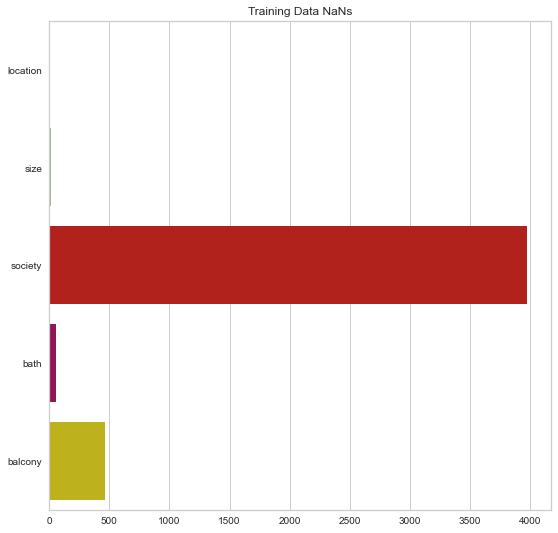

['ID']
Duplicates in data:  905
Duplicates in id columns:  0
When filtering out id columns:  ['ID']
******
Detecting NaNs in Testing Data
******
NaNs in data: 497
******
NaNs in size:  1
NaNs in society:  452
NaNs in bath:  4
NaNs in balcony:  40
******



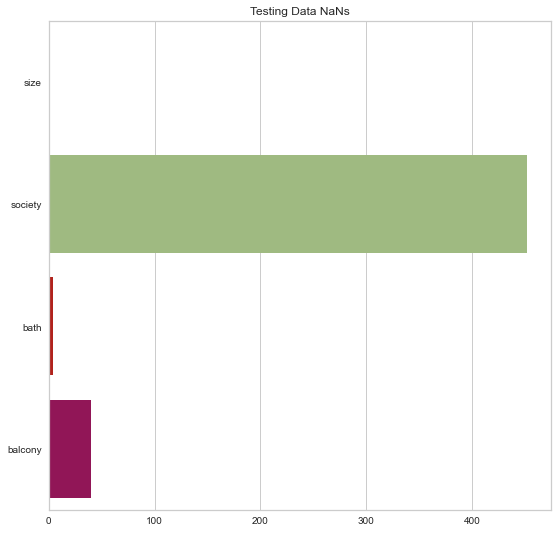

['ID']
Duplicates in data:  24
Duplicates in id columns:  0
When filtering out id columns:  ['ID']
Removed Uncorrelated:  ['location_was_null', 'area_type_Carpet  Area']


ID  availability  location  size  society  total_sqft  bath  balcony  \
0   0            36       367    12      377          65   2.0      1.0   
1   1            76       277    18     2030        1138   5.0      3.0   
2   2            76      1047    15        0        1825   2.0      3.0   
3   3            76       792    15     1195        1825   3.0      1.0   

   ID_was_null  area_type_was_null  ...  location_X_society  \
0            0                   0  ...              138359   
1            0                   0  ...              562310   
2            0                   0  ...                   0   
3            0                   0  ...              946440   

   location_X_total_sqft  society_X_total_sqft  A1_iter_score  A2_iter_score  \
0                  23855                 24505             36            403   
1                 315226               2310140             77            354   
2                1910775                     0             78           1125   
3                1445400               2180875             79            871   

   A3_iter_score  A4_iter_score  anomaly_IsolationForest  \
0            780            845                        0   
1           2384           3522                        0   
2           1125           2950                        0   
3           2066           3891                        1   

   anomaly_score_IsolationForest   price  
0                      -0.524099   39.07  
1                      -0.608688  120.00  
2                      -0.555375   62.00  
3                      -0.489636   95.00  

[4 rows x 36 columns]

In [22]:
fe = rabbitml.feature_engineering()
df, test_df = fe.pipeline(df, test_df, target_col="price")
df.head(4)

# Exploratory Data Analysis

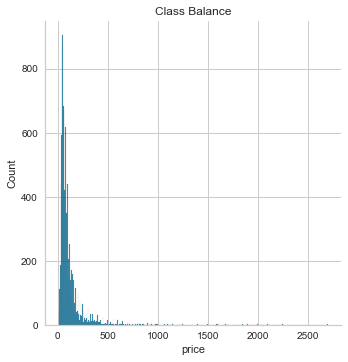

***
Dimensional Reduction
***
35 initial feature components
95% variance explained by 8 components by principle component analysis
69% variance explained by 3 components by principle component analysis
59% variance explained by 2 components by principle component analysis


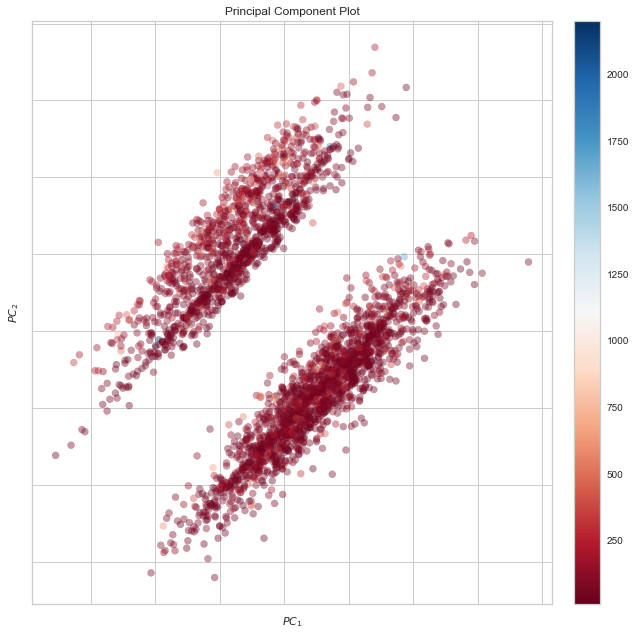

/Users/raj8lm/opt/miniconda3/lib/python3.7/site-packages/yellowbrick/features/pca.py:458: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



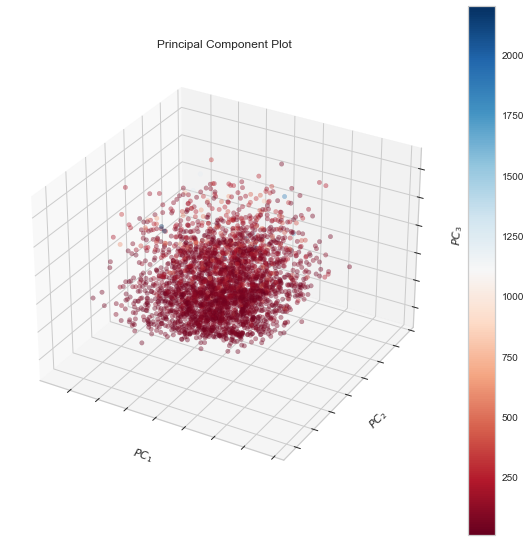

***
Box Plots
***


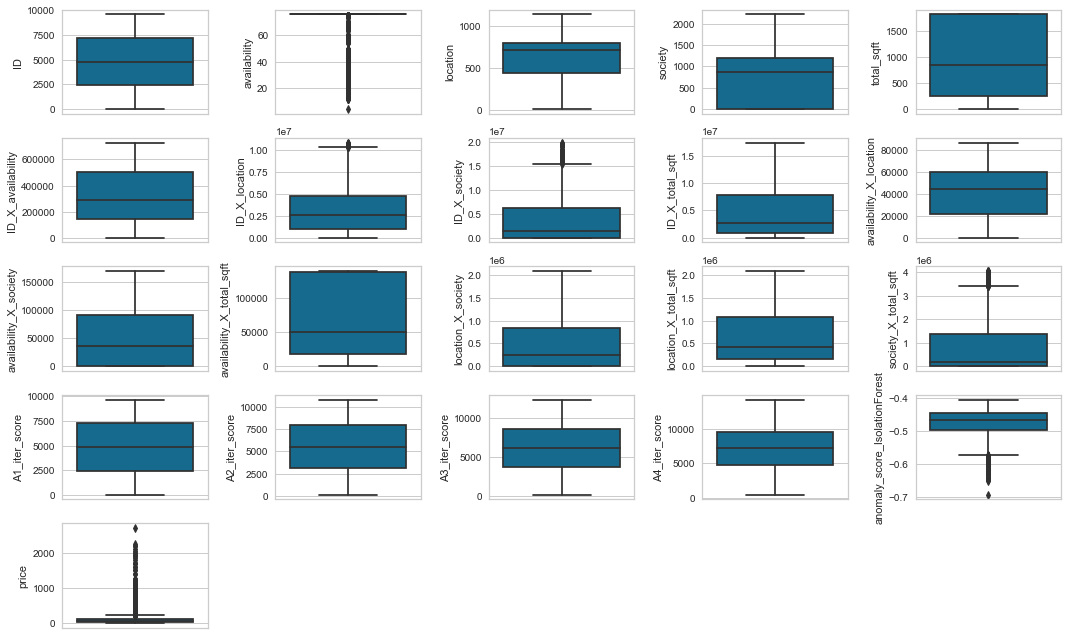

***
Line Plots
***


/Users/raj8lm/opt/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.

/Users/raj8lm/opt/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



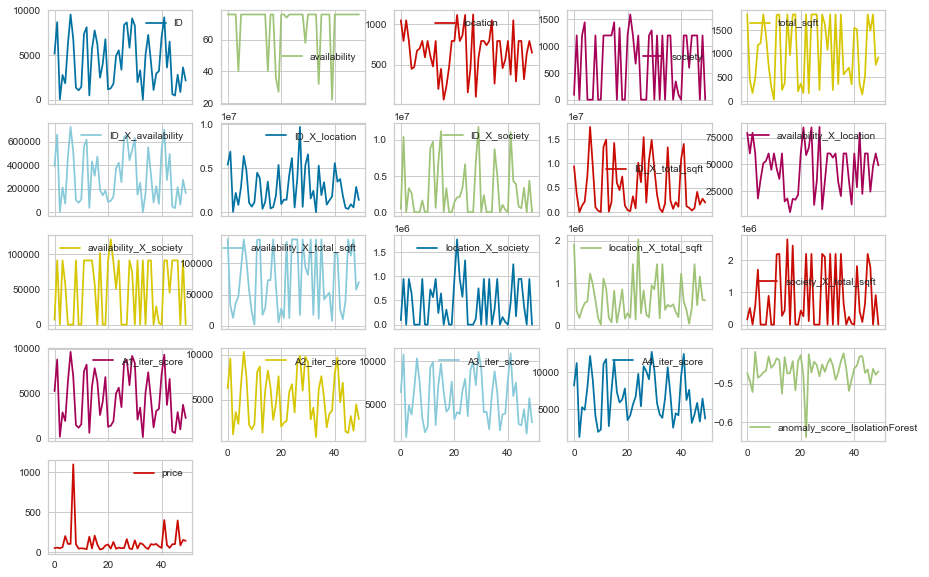

***
Correlations
***
Correlations with price:
price : 1.0
bath : 0.4646775869449468
size : 0.4534655703905558
area_type_Plot  Area : 0.27048380378613385
balcony_was_null : 0.20991851261351774
anomaly_score_IsolationForest : 0.2057396157848619
location_X_total_sqft : 0.20065185631166615
availability_X_total_sqft : 0.19047560999228297
total_sqft : 0.18351496945990406
area_type_Super built-up  Area : 0.18113660651018498


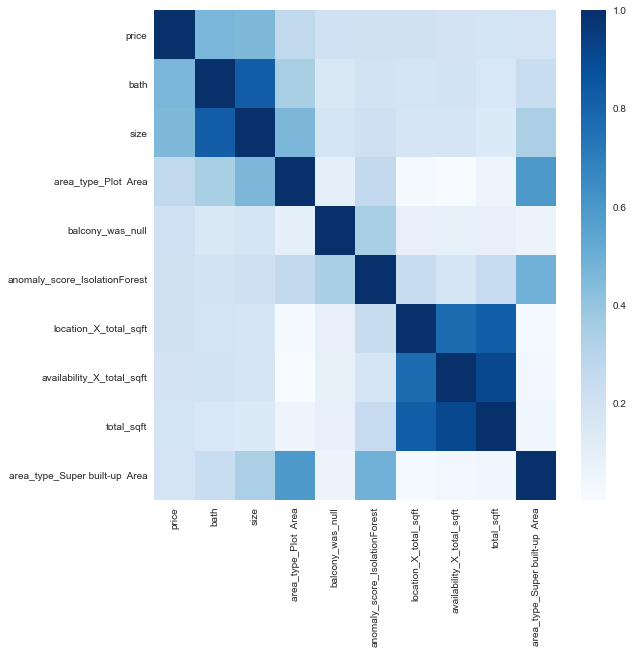

***
Pair Grid Plot
***
Correlations with price:
price : 1.0
bath : 0.4420051105830518
size : 0.37392713862036553
area_type_Plot  Area : 0.27048380378613385
anomaly_score_IsolationForest : 0.22546071089798925


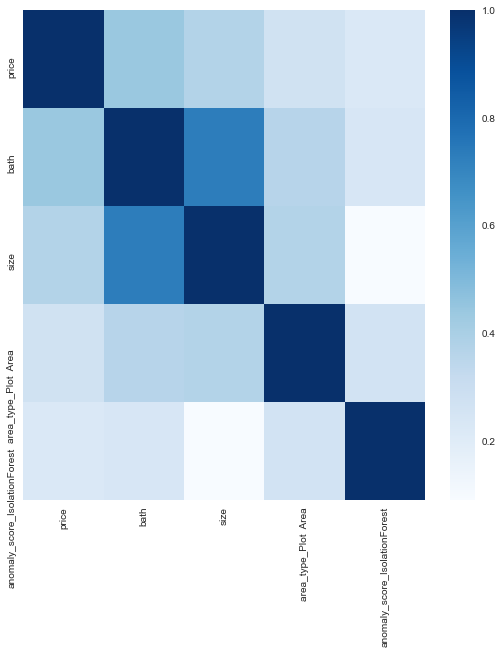

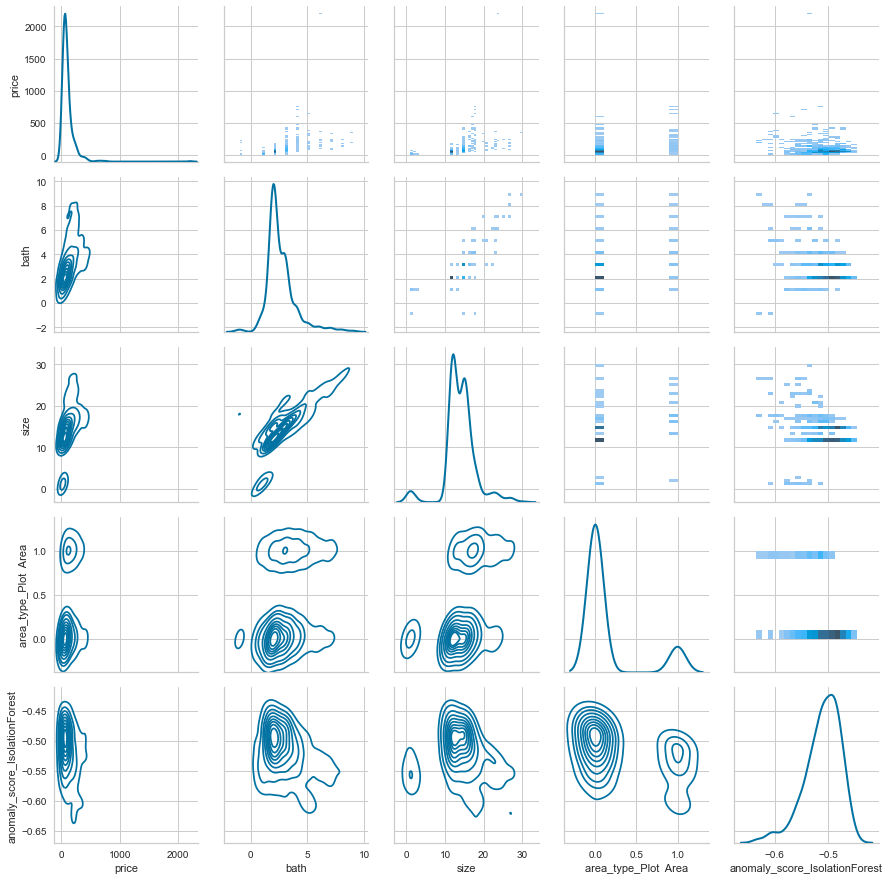

***
Decision Tree
***
accuracy: 0.42179353493222105


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

***
Anomalies
***


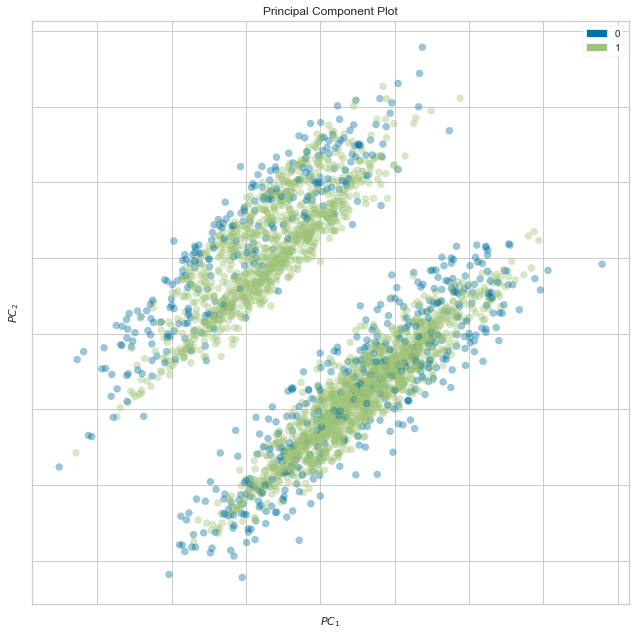

***
Normality Test
***


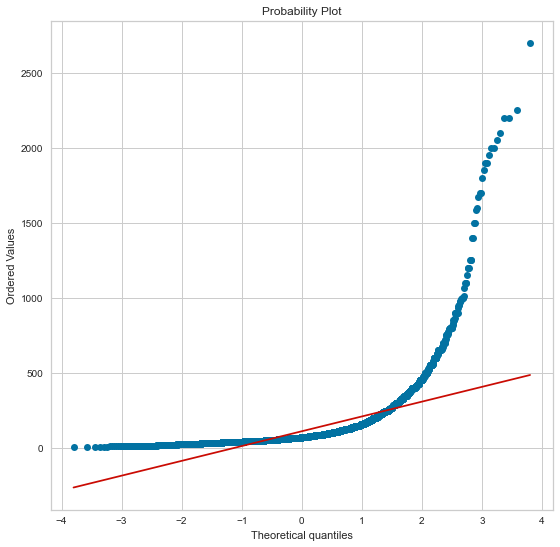

***
Pivot Table
***


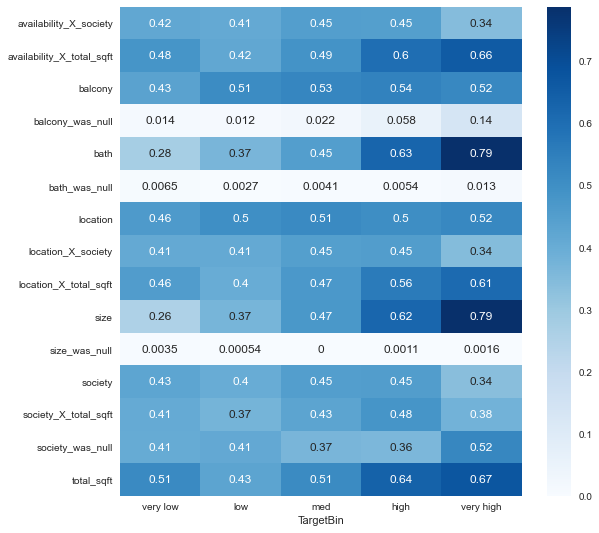

***
Manifold Embedding
***


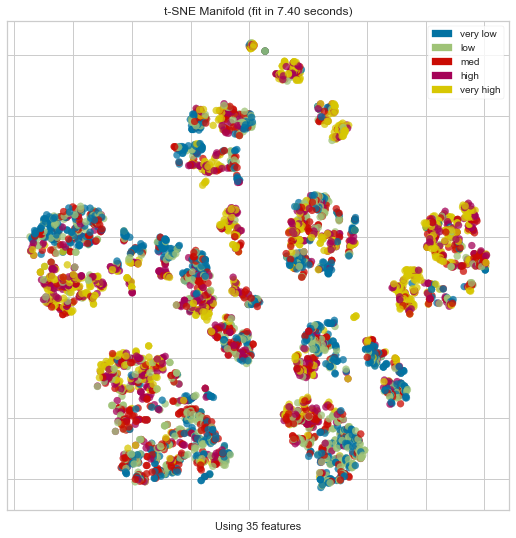

In [23]:
eda = rabbitml.eda()
eda.pipeline(df, "price", fe, "regression")
display()

# Feature Selection

In [24]:
scaled_df = fe.quantile_transform_column_wise(df, "price")
new_features = rabbitml.feature_selection.kendall_tau_feature_elimination(scaled_df, scaled_df.columns, "price", 0.001)
eliminated_df = scaled_df.copy()[new_features]
eliminated_df.head(3)

availability  location      size   society  total_sqft      bath   balcony  \
0       0.14014  0.208208  0.246747  0.445445    0.048850  0.325826  0.308809   
1       1.00000  0.156156  0.907908  0.990991    0.548048  0.941942  1.000000   
2       1.00000  0.900400  0.629129  0.000000    1.000000  0.325826  1.000000   

   society_was_null  balcony_was_null  area_type_Built-up  Area  ...  \
0               0.0               0.0                       0.0  ...   
1               0.0               0.0                       0.0  ...   
2               1.0               0.0                       1.0  ...   

   ID_X_location  ID_X_society  ID_X_total_sqft  availability_X_location  \
0       0.000000      0.000000         0.000000                 0.132975   
1       0.000058      0.414587         0.001474                 0.238238   
2       0.000441      0.000000         0.003666                 0.922923   

   availability_X_total_sqft  location_X_total_sqft  society_X_total_sqft  \
0                   0.032097               0.054534              0.427143   
1                   0.634635               0.437186              0.944910   
2                   1.000000               0.959459              0.000000   

   anomaly_IsolationForest  anomaly_score_IsolationForest   price  
0                      0.0                       0.105354   39.07  
1                      0.0                       0.003972  120.00  
2                      0.0                       0.033279   62.00  

[3 rows x 22 columns]

# Prediction

LinearRegression Score: 0.26824851862741905
LinearRegression MAE Accuracy: 57.03292692320364
***
RidgeRegression Score: 0.2683458771602642
RidgeRegression MAE Accuracy: 56.99931036039534
***
Lasso Score: 0.2664138162337365
Lasso MAE Accuracy: 55.18234065948957
***
ElasticNet Score: 0.1400624598555465
ElasticNet MAE Accuracy: 62.69842106628393
***
LassoLARS Score: -0.0006386200498308181
LassoLARS MAE Accuracy: 73.5278829523498
***
BayesianRidge Score: 0.26863633705284357
BayesianRidge MAE Accuracy: 56.86146362222551
***
ARDRegression Score: 0.2675122645886602
ARDRegression MAE Accuracy: 56.84622140900382
***
Stochastic Gradient Descent Score: 0.2651185714901555
Stochastic Gradient Descent MAE Accuracy: 56.81328024720307
***
Huber Regressor Score: 0.1975303805466587
Huber Regressor MAE Accuracy: 48.69322280106111
***
GradientBoostingRegressor Score: 0.16570385054759945
GradientBoostingRegressor MAE Accuracy: 65.12379497500605
***
RandomForestRegressor Score: 0.23439394100833658
RandomFor

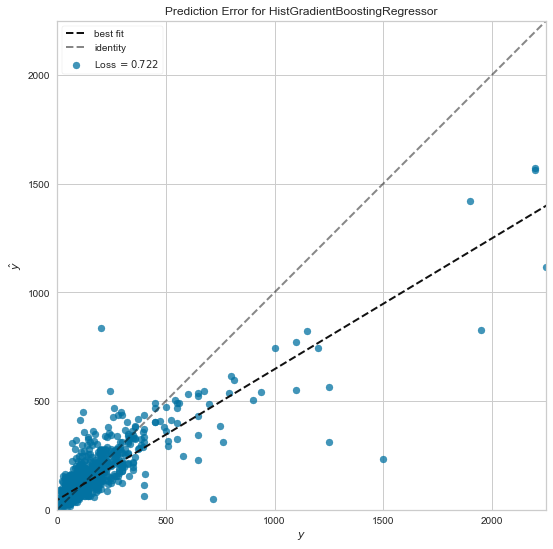

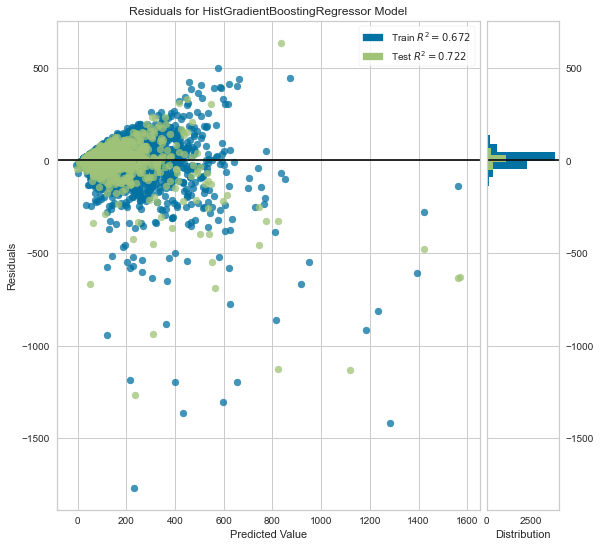

In [25]:
predictor = rabbitml.prediction()
regrs = predictor.regression_pipeline(eliminated_df, "price")

In [26]:
fe.drop_unshared_columns(eliminated_df, test_df, "price")
test_df = fe.quantile_transform_column_wise(test_df, "price")
# Print metrics
predictor.regression_results(test_true_y, regrs[0][0].predict(test_df.values))

Explained Variance:      0.2346
Mean Squared Log Error:  0.3167
R2:                      0.2257
Mean Absolute Error:     59.5453
Mean Squared Error:      16746.8187
Root Mean Square Error:  129.4095


# Conclusion

This was an interesting dataset to look at. Interesting that bathrooms are such an important feature. If I was to go further I would attempt to use a power transformer to normalise the price to attempt to make better predictions on it. Clustering and PCA might be very useful as well, the EDA showed a lot of explained variance could be retained while reducing the dimensional space. The holdout test data shows overfitting in the model I produced. 

In [27]:
df_test = pd.read_csv("test.csv")

In [28]:
test_df_1 = fe.quantile_transform_column_wise(df_test, "price")

ValueError: could not convert string to float: 'Super built-up  Area'

In [ ]:
test_df_1.head()